In [1]:
# Imports and functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import _lib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from tabulate import tabulate
import sklearn.metrics as sk
import seaborn as sns
import numpy as np
import xgboost as xg
import pickle as pk

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



def findCell(dataframe, label, column):
    print(dataframe.loc[label, column])


def metrics(Y_true, Y_pred):
    rSquared = sk.r2_score(Y_true, Y_pred) #1 is best
    MSE = sk.mean_squared_error(Y_true, Y_pred, squared = True) #0 is best
    RMSE = sk.mean_squared_error(Y_true, Y_pred, squared = False) #0 is best
    MAE = sk.mean_absolute_error(Y_true, Y_pred) #0 is best
    metric_dict = {'R^2': rSquared, 'MSE': MSE, 'RMSE': RMSE, 'MAE': MAE}
    return metric_dict
    
def trees(X_train, Y_train, X_test, Y_test, params, num_boost): #use this after every grid search, update params
    dtrain = xg.DMatrix(X_train, label = Y_train)
    dtest = xg.DMatrix(X_test, label = Y_test)
    params['eval_metric'] = "mae"
    model = xg.train(params, dtrain, num_boost_round = num_boost, early_stopping_rounds = 100, evals = [(dtest, "test")]) #evals is testing set
    print("Best MAE: {:.2f} with {} rounds".format(model.best_score, model.best_iteration+1))
    
    
    


In [2]:
#DATA

data = pd.read_csv("C:\\Users\opoob\Desktop\ML Healthcare\Datasets\IllnessTwoFinal.csv")
data


#Notes
#facility ID = 0 is rows with "none" as ID
#Gender is 1 for Male, 0 for Female
#ER Indicator is 1 for Yes, 0 For No
#120 + length of stay is 120 for now

#Tracking
#...StayLength converts stays >120 to 120

,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Admit Day of Week,Type of Admission,...,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Source of Payment 1,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,1,Albany Medical Center Hospital,70 or Older,120,M,White,Not Span/Hispanic,4,None,Emergency,...,2,Moderate,Moderate,Medical,Medicare,0,N,Y,27036.07,6272.92
1,1,Albany Medical Center Hospital,70 or Older,121,M,White,Not Span/Hispanic,1,None,Emergency,...,4,Extreme,Extreme,Medical,Medicare,0,N,Y,15755.84,3336.00
2,1,Albany Medical Center Hospital,0 to 17,121,F,White,Not Span/Hispanic,2,None,Emergency,...,1,Minor,Minor,Medical,Medicaid,0,N,Y,12272.19,3548.33
3,1,Albany Medical Center Hospital,50 to 69,122,F,White,Not Span/Hispanic,3,None,Emergency,...,2,Moderate,Moderate,Medical,Medicare,0,N,Y,18068.96,5030.95
4,1,Albany Medical Center Hospital,50 to 69,124,F,White,Not Span/Hispanic,1,None,Emergency,...,2,Moderate,Minor,Medical,Medicaid,0,N,Y,13229.82,2228.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167469,3975,New York Presbyterian Hospital - Allen Hospital,50 to 69,104,M,Other Race,Spanish/Hispanic,4,None,Emergency,...,2,Moderate,Moderate,Medical,Medicaid,0,N,Y,43256.85,11555.56
167470,3975,New York Presbyterian Hospital - Allen Hospital,70 or Older,100,M,Other Race,Not Span/Hispanic,2,None,Emergency,...,1,Minor,Minor,Medical,Medicare,0,N,Y,28661.81,7589.06
167471,3975,New York Presbyterian Hospital - Allen Hospital,30 to 49,100,F,Other Race,Not Span/Hispanic,3,None,Emergency,...,1,Minor,Minor,Medical,Private Health Insurance,0,N,Y,51687.81,13087.85
167472,3975,New York Presbyterian Hospital - Allen Hospital,70 or Older,104,F,Other Race,Not Span/Hispanic,2,None,Emergency,...,1,Minor,Moderate,Medical,Medicare,0,N,Y,20596.09,5734.32


In [3]:
fac = data['Facility Name'].value_counts().head(10)
fac


NewYork-Presbyterian/Queens                           3687
North Shore University Hospital                       3259
Montefiore Medical Center - Henry & Lucy Moses Div    2970
Rochester General Hospital                            2871
Vassar Brothers Medical Center                        2856
Maimonides Medical Center                             2836
Long Island Jewish Medical Center                     2539
Good Samaritan Hospital Medical Center                2522
Strong Memorial Hospital                              2371
NewYork-Presbyterian Brooklyn Methodist Hospital      2357
Name: Facility Name, dtype: int64

In [4]:
#pull facility ID codes with FindMatch.py
# 181:Vassar Brothers Medical Center
# 411:Rochester General Hospital
# 413:Strong Memorial Hospital
# 541:North Shore University Hospital
# 925:Good Samaritan Hospital Medical Center
# 1169:Montefiore Medical Center - Henry & Lucy Moses Div
# 1305:Maimonides Medical Center
# 1306:NewYork-Presbyterian Brooklyn Methodist Hospital
# 1630:Long Island Jewish Medical Center
# 1637:NewYork-Presbyterian/Queens
#20771 of desired rows have id in int(), other 2739 have it in str()

hospitals = {181: 'Vassar Brothers Medical Center', 925: 'Good Samaritan Hospital Medical Center', 411: 'Rochester General Hospital'\
            , 541: 'North Shore University Hospital', 413: 'Strong Memorial Hospital', 1169: 'Montefiore Medical Center - Henry & Lucy Moses Div', \
            1305: 'Maimonides Medical Center', 1630: 'Long Island Jewish Medical Center', 1637: 'NewYork-Presbyterian/Queens', 1306: 'NewYork-Presbyterian Brooklyn Methodist Hospital'}

data.astype({'Facility ID': 'int32'}) 
reduced = data[data['Facility ID'].isin(hospitals)] 
reduced

,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Admit Day of Week,Type of Admission,...,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Source of Payment 1,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,1,Albany Medical Center Hospital,70 or Older,120,M,White,Not Span/Hispanic,4,None,Emergency,...,2,Moderate,Moderate,Medical,Medicare,0,N,Y,27036.07,6272.92
1,1,Albany Medical Center Hospital,70 or Older,121,M,White,Not Span/Hispanic,1,None,Emergency,...,4,Extreme,Extreme,Medical,Medicare,0,N,Y,15755.84,3336.00
2,1,Albany Medical Center Hospital,0 to 17,121,F,White,Not Span/Hispanic,2,None,Emergency,...,1,Minor,Minor,Medical,Medicaid,0,N,Y,12272.19,3548.33
3,1,Albany Medical Center Hospital,50 to 69,122,F,White,Not Span/Hispanic,3,None,Emergency,...,2,Moderate,Moderate,Medical,Medicare,0,N,Y,18068.96,5030.95
4,1,Albany Medical Center Hospital,50 to 69,124,F,White,Not Span/Hispanic,1,None,Emergency,...,2,Moderate,Minor,Medical,Medicaid,0,N,Y,13229.82,2228.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167469,3975,New York Presbyterian Hospital - Allen Hospital,50 to 69,104,M,Other Race,Spanish/Hispanic,4,None,Emergency,...,2,Moderate,Moderate,Medical,Medicaid,0,N,Y,43256.85,11555.56
167470,3975,New York Presbyterian Hospital - Allen Hospital,70 or Older,100,M,Other Race,Not Span/Hispanic,2,None,Emergency,...,1,Minor,Minor,Medical,Medicare,0,N,Y,28661.81,7589.06
167471,3975,New York Presbyterian Hospital - Allen Hospital,30 to 49,100,F,Other Race,Not Span/Hispanic,3,None,Emergency,...,1,Minor,Minor,Medical,Private Health Insurance,0,N,Y,51687.81,13087.85
167472,3975,New York Presbyterian Hospital - Allen Hospital,70 or Older,104,F,Other Race,Not Span/Hispanic,2,None,Emergency,...,1,Minor,Moderate,Medical,Medicare,0,N,Y,20596.09,5734.32


,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Admit Day of Week,Type of Admission,...,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Source of Payment 1,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
3451,181,Vassar Brothers Medical Center,70 or Older,125,M,White,Not Span/Hispanic,3,None,Emergency,...,4,Extreme,Extreme,Medical,Medicare,0,N,Y,26030.81,6069.91
3452,181,Vassar Brothers Medical Center,0 to 17,125,M,White,Not Span/Hispanic,2,None,Emergency,...,2,Moderate,Minor,Medical,Blue Cross/Blue Shield,0,N,Y,11669.96,3985.52
3453,181,Vassar Brothers Medical Center,70 or Older,126,F,White,Not Span/Hispanic,7,None,Emergency,...,3,Major,Major,Medical,Medicare,0,N,Y,40638.29,10541.50
3454,181,Vassar Brothers Medical Center,70 or Older,126,M,White,Not Span/Hispanic,10,None,Emergency,...,3,Major,Major,Medical,Medicare,0,N,Y,44595.56,12435.57
3455,181,Vassar Brothers Medical Center,70 or Older,125,M,White,Not Span/Hispanic,2,None,Emergency,...,3,Major,Moderate,Medical,Medicare,0,N,Y,11338.62,3037.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165260,1637,NewYork-Presbyterian/Queens,30 to 49,114,F,Other Race,Spanish/Hispanic,4,None,Emergency,...,1,Minor,Minor,Medical,Medicaid,0,N,Y,24592.00,7489.67
165261,1637,NewYork-Presbyterian/Queens,50 to 69,113,M,White,Spanish/Hispanic,1,None,Emergency,...,1,Minor,Minor,Medical,Medicaid,0,N,N,4944.26,1525.77
165262,1637,NewYork-Presbyterian/Queens,50 to 69,113,F,Other Race,Not Span/Hispanic,6,None,Emergency,...,3,Major,Major,Medical,Medicare,0,N,Y,45012.78,14115.53
165263,1637,NewYork-Presbyterian/Queens,50 to 69,113,M,Other Race,Not Span/Hispanic,8,None,Emergency,...,2,Moderate,Minor,Medical,Medicare,0,N,Y,49523.95,13646.85


In [5]:
reduced = reduced.drop(columns = ['Abortion Edit Indicator','Admit Day of Week', 'Birth Weight'])

#APR MDC Description/Code can go because its DRG but less specific, APR Severity Description might need to go too
#Collinearity: Facility Name, Day of Week, CSS Diagnosis Code, CSS Diagnosis Description, CCS Procedure Name, APR DRG Code, APR MDC Code/Description, APR Severity Description
reduced = reduced.drop(columns = ['Facility Name','Discharge Day of Week','CCS Diagnosis Code','CCS Diagnosis Description','CCS Procedure Description','APR DRG Code','APR MDC Code','APR MDC Description','APR Severity of Illness Description'])
reduced.dtypes




Facility ID                           int64
Age Group                            object
Zip Code - 3 digits                  object
Gender                               object
Race                                 object
Ethnicity                            object
Length of Stay                        int64
Type of Admission                    object
Patient Disposition                  object
Discharge Year                        int64
CCS Procedure Code                    int64
APR DRG Description                  object
APR Severity of Illness Code          int64
APR Risk of Mortality                object
APR Medical Surgical Description     object
Source of Payment 1                  object
Emergency Department Indicator       object
Total Charges                       float64
Total Costs                         float64
dtype: object

In [6]:
reduced = reduced.astype({'Facility ID': 'object', 'Length of Stay': 'int64', 'Discharge Year': 'object', 'CCS Procedure Code': 'object'})
reduced.dtypes

#Keep Zip As Obj Because No Associative Effect
#Stay -> Int
#Discharge Year -> Obj, CCS Diagnosis -> Obj, CCS Procedure -> Obj, APR DRG Code -> Obj, APR MDC Code -> Obj, Facility ID -> Obj
#If greater number doesn't mean anything, convert to object & treat as categorical. So, only severity and stay should be integers.

#---------------------------- Testing Section
reducedTwo = reduced[reduced['Total Charges'] < 100000.00]

Facility ID                          object
Age Group                            object
Zip Code - 3 digits                  object
Gender                               object
Race                                 object
Ethnicity                            object
Length of Stay                        int64
Type of Admission                    object
Patient Disposition                  object
Discharge Year                       object
CCS Procedure Code                   object
APR DRG Description                  object
APR Severity of Illness Code          int64
APR Risk of Mortality                object
APR Medical Surgical Description     object
Source of Payment 1                  object
Emergency Department Indicator       object
Total Charges                       float64
Total Costs                         float64
dtype: object

In [7]:
#X stores characters used to determine final value
#remove potential Y values
X = reduced.drop(columns = ['Total Charges','Total Costs'])

X

#---------------------------- Testing Section
X2 = reducedTwo.drop(columns = ['Total Charges','Total Costs'])
print('ran')

,Facility ID,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,Discharge Year,CCS Procedure Code,APR DRG Description,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Source of Payment 1,Emergency Department Indicator
3451,181,70 or Older,125,M,White,Not Span/Hispanic,3,Emergency,Home or Self Care,2016,0,Other pneumonia,4,Extreme,Medical,Medicare,Y
3452,181,0 to 17,125,M,White,Not Span/Hispanic,2,Emergency,Home or Self Care,2016,0,Other pneumonia,2,Minor,Medical,Blue Cross/Blue Shield,Y
3453,181,70 or Older,126,F,White,Not Span/Hispanic,7,Emergency,Home or Self Care,2016,0,Other pneumonia,3,Major,Medical,Medicare,Y
3454,181,70 or Older,126,M,White,Not Span/Hispanic,10,Emergency,Skilled Nursing Home,2016,0,Other pneumonia,3,Major,Medical,Medicare,Y
3455,181,70 or Older,125,M,White,Not Span/Hispanic,2,Emergency,Home or Self Care,2016,0,Other pneumonia,3,Moderate,Medical,Medicare,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165260,1637,30 to 49,114,F,Other Race,Spanish/Hispanic,4,Emergency,Home w/ Home Health Services,2016,231,Cellulitis & other skin infections,1,Minor,Medical,Medicaid,Y
165261,1637,50 to 69,113,M,White,Spanish/Hispanic,1,Emergency,Home w/ Home Health Services,2016,174,Cellulitis & other skin infections,1,Minor,Medical,Medicaid,N
165262,1637,50 to 69,113,F,Other Race,Not Span/Hispanic,6,Emergency,Home w/ Home Health Services,2016,231,Cellulitis & other skin infections,3,Major,Medical,Medicare,Y
165263,1637,50 to 69,113,M,Other Race,Not Span/Hispanic,8,Emergency,Home or Self Care,2016,177,Cellulitis & other skin infections,2,Minor,Medical,Medicare,Y


ran


In [8]:
#Y = pd.DataFrame(data = reduced, columns = ['Total Charges'])

Y = pd.DataFrame(data = reduced, columns = ['Total Charges'])
Y
data_sum = Y['Total Charges'].describe().apply("{0:.5f}".format)
data_sum
#print(tabulate(data_sum, headers = ['Summary Statistic', 'Value'], tablefmt='fancy_grid')) #summary statistics of charges

#---------------------------- Testing Section
Y2 = pd.DataFrame(data = reducedTwo, columns = ['Total Charges'])

,Total Charges
3451,26030.81
3452,11669.96
3453,40638.29
3454,44595.56
3455,11338.62
...,...
165260,24592.00
165261,4944.26
165262,45012.78
165263,49523.95


count      28268.00000
mean       54040.41291
std        63181.04746
min         1326.10000
25%        19840.71500
50%        35926.10500
75%        64914.34750
max      1464073.64000
Name: Total Charges, dtype: object

In [9]:
X = pd.get_dummies(X, prefix_sep = '_')
X

#---------------------------- Testing Section
X2 = pd.get_dummies(X2, prefix_sep = '_')

,Length of Stay,APR Severity of Illness Code,Facility ID_181,Facility ID_411,Facility ID_413,Facility ID_541,Facility ID_925,Facility ID_1169,Facility ID_1305,Facility ID_1306,...,Source of Payment 1_Department of Corrections,Source of Payment 1_Federal/State/Local/VA,"Source of Payment 1_Managed Care, Unspecified",Source of Payment 1_Medicaid,Source of Payment 1_Medicare,Source of Payment 1_Miscellaneous/Other,Source of Payment 1_Private Health Insurance,Source of Payment 1_Self-Pay,Emergency Department Indicator_N,Emergency Department Indicator_Y
3451,3,4,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3452,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3453,7,3,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3454,10,3,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3455,2,3,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165260,4,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
165261,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
165262,6,3,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
165263,8,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [10]:
X.rename(columns={'Emergency Department Indicator_Y':'Emergency Department Indicator'}, inplace = True) #1 yes 0 no
X.rename(columns={'Gender_M':'Gender'}, inplace = True) #1 yes 0 no
X.drop(columns = {'Emergency Department Indicator_N', 'Gender_F'}, inplace = True)
X.drop(columns = {'Gender'}, inplace = True) #removing gender
X

#---------------------------- Testing Section
X2.rename(columns={'Emergency Department Indicator_Y':'Emergency Department Indicator'}, inplace = True) #1 yes 0 no
X2.rename(columns={'Gender_M':'Gender'}, inplace = True) #1 yes 0 no
X2.drop(columns = {'Emergency Department Indicator_N', 'Gender_F'}, inplace = True)

,Length of Stay,APR Severity of Illness Code,Facility ID_181,Facility ID_411,Facility ID_413,Facility ID_541,Facility ID_925,Facility ID_1169,Facility ID_1305,Facility ID_1306,...,Source of Payment 1_Blue Cross/Blue Shield,Source of Payment 1_Department of Corrections,Source of Payment 1_Federal/State/Local/VA,"Source of Payment 1_Managed Care, Unspecified",Source of Payment 1_Medicaid,Source of Payment 1_Medicare,Source of Payment 1_Miscellaneous/Other,Source of Payment 1_Private Health Insurance,Source of Payment 1_Self-Pay,Emergency Department Indicator
3451,3,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3452,2,2,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3453,7,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3454,10,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3455,2,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165260,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
165261,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
165262,6,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
165263,8,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


[0.84731877 0.87242191]


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

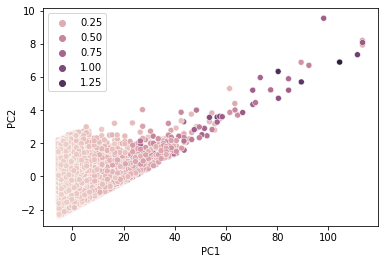

In [11]:
pca = PCA(n_components = 2) #pca
pcaX = pca.fit(X).transform(X) 
pcaX = pd.DataFrame(data = pcaX, columns = ['PC1','PC2'])
print(np.cumsum(pca.explained_variance_ratio_)) 
color = Y['Total Charges'].values 
plot = sns.scatterplot(data = pcaX, x = 'PC1', y = 'PC2', hue = color, legend = 'auto') 
plot #see graph has clear color separation -> good gradients for ML, perhaps good predictions


#---------------------------- Testing Section
# pcaTwo = PCA(n_components = 2)
# pcaX2 = pcaTwo.fit(X2).transform(X2)
# pcaX2 = pd.DataFrame(data = pcaX2, columns = ['PC1','PC2'])
# print(np.cumsum(pcaTwo.explained_variance_ratio_))
# colorTwo = Y2['Total Charges'].values
# plot2 = sns.scatterplot(data = pcaX2, x = 'PC1', y = 'PC2', hue = colorTwo, legend = 'auto')
# plot2

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, train_size = 0.9, shuffle = True) #matches X and Y dataframes
print(type(X_train))
print(type(Y_train))

#---------------------------- Testing Section
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.1, train_size = 0.9, shuffle = True) #matches X and Y dataframes

 

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [13]:
#Grid Search
#params can be set with dictionary or as parameter
defparams = {
    # Default params
    'max_depth': 7,
    'min_child_weight': 4,
    'eta': .1,
    'gamma': 0,
    'subsample': 0.9,
    'colsample_bytree': 1,
    'reg_alpha': 1e-5,
    'reg_lambda': 10
}
params_t1 = {
    'max_depth': range(2, 11, 2),
    'min_child_weight': range(1, 6, 2)
}
params_t2 = { #7, 4 is best
    'max_depth': [5, 6, 7],
    'min_child_weight': [2, 3, 4]
}
params_t3 = { #gamma 0 best
    'gamma': range(0, 11)
}
params_t4 = { #0.9, 1 best
 'subsample': [i/10.0 for i in range(6,11)], #0.6, 0.7, 0.8, 0.9
 'colsample_bytree': [i/10.0 for i in range(6,11)]
}
params_t5 = {
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.95, 1]
}
params_t6 = { #1e-5 and 10 are best
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'reg_lambda': [1, 5, 10, 50]

}
params_t7 = { #10 best
    'reg_lambda': [8, 10, 12, 14, 16]
}


#trees(X_train, Y_train, X_test, Y_test, defparams, 900)
# model = xg.XGBRegressor(n_estimators=212, max_depth=7, min_child_weight = 4, eta=0.1, gamma = 0, subsample = 0.9, colsample_bytree = 1.0, reg_alpha = 1e-5, reg_lambda = 10)
# gs = GridSearchCV(model, params_t1, scoring = 'neg_mean_absolute_error', cv = 20, n_jobs = -1)
# gs.fit(X_train, Y_train)
# gs.best_params_
# gs.best_estimator_
# gs.best_score_





In [14]:
tot_mae = 0
tot_r2 = 0
c = 0

while(c < 10):

    #Real Models on Whole Dataset
    model = xg.XGBRegressor(n_estimators=212, max_depth=7, min_child_weight = 4, eta=0.1, gamma = 0, subsample = 0.9, colsample_bytree = 1.0, reg_alpha = 1e-5, reg_lambda = 10)
    model.fit(X_train, np.ravel(Y_train))
    Y_pred = model.predict(X_test)

    #Metrics for Real Models

    metric_dict = metrics(np.ravel(Y_test.values), np.ravel(Y_pred))
    tot_mae += metric_dict['MAE']
    tot_r2 += metric_dict['R^2']
    
    c += 1
    
print('Average MAE is ' + str(tot_mae/10))
print('Average R2 is ' + str(tot_r2/10))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=212, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1e-05, reg_lambda=10, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

Average MAE is 8855.18281046233
Average R2 is 0.9098613165857101


677640.0
543252.25


Text(0.5, 1.0, 'Predicted Charges vs. Actual Charges')

Text(0.5, 0, 'Actual Charges ($)')

Text(0, 0.5, 'Predicted Charges ($)')

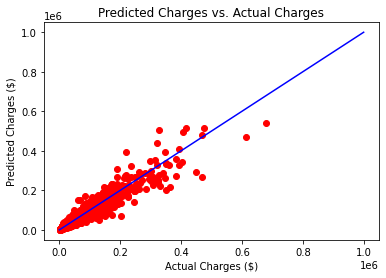

In [15]:
#Plotting
print(np.amax(np.ravel(Y_test.values)))
print(np.amax(np.ravel(Y_pred)))
plt.scatter(np.ravel(Y_test.values), np.ravel(Y_pred), color = 'red')
line = np.linspace(0, 1000000, 1000000) #sets axis spacing
c = line
plt.plot(line, c, 'b')

plt.title('Predicted Charges vs. Actual Charges')
plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.show()


In [16]:
#Weights

weights = model.get_booster().get_score(importance_type = 'weight') #dictionary
weight_dict = {}
count = {}

for key in weights:
    if '_' in key:
        index = key.index('_')
        mkey = key[:index]
        if mkey not in weight_dict:
            weight_dict[mkey] = 0
            count[mkey] = 0
            
        weight_dict[mkey] += weights[key]
        count[mkey] += 1
        
    else:
        if key not in weight_dict:
            weight_dict[key] = 0
            count[key] = 0
        weight_dict[key] += weights[key]
        count[key] += 1


for key in weight_dict:
    weight_dict[key] = weight_dict[key]/count[key]
    
sort = sorted(weight_dict.items(), key = lambda x: x[1], reverse = True)
sort
print(tabulate(sort, headers = ['Feature', 'Weight'], tablefmt='fancy_grid'))

#lambda is a function and x is a parameter, each time iterable calls lambda with x as parameter, lambda gives back each item's value. for any k/v pair, x[0] is key and x[1] is value 

[('Length of Stay', 2176.0),
 ('APR Severity of Illness Code', 341.0),
 ('Facility ID', 142.3),
 ('Emergency Department Indicator', 139.0),
 ('APR Risk of Mortality', 112.5),
 ('Race', 97.5),
 ('Age Group', 90.4),
 ('APR DRG Description', 68.0),
 ('Source of Payment 1', 64.2),
 ('Patient Disposition', 50.0),
 ('Ethnicity', 32.0),
 ('Zip Code - 3 digits', 25.72),
 ('CCS Procedure Code', 21.354166666666668),
 ('Type of Admission', 13.666666666666666)]

╒════════════════════════════════╤═══════════╕
│ Feature                        │    Weight │
╞════════════════════════════════╪═══════════╡
│ Length of Stay                 │ 2176      │
├────────────────────────────────┼───────────┤
│ APR Severity of Illness Code   │  341      │
├────────────────────────────────┼───────────┤
│ Facility ID                    │  142.3    │
├────────────────────────────────┼───────────┤
│ Emergency Department Indicator │  139      │
├────────────────────────────────┼───────────┤
│ APR Risk of Mortality          │  112.5    │
├────────────────────────────────┼───────────┤
│ Race                           │   97.5    │
├────────────────────────────────┼───────────┤
│ Age Group                      │   90.4    │
├────────────────────────────────┼───────────┤
│ APR DRG Description            │   68      │
├────────────────────────────────┼───────────┤
│ Source of Payment 1            │   64.2    │
├────────────────────────────────┼───────────┤
│ Patient Dis

In [17]:
# Saving the model as a pickle file

# file = 'ModelSaved.sav'
# pk.dump(model, open(file, 'wb'))



In [18]:
# loaded = pk.load(open(file, 'rb'))
# Y_pred = loaded.predict(X_test)
# metrics(np.ravel(Y_test.values), np.ravel(Y_pred))
# print(np.ravel(Y_test.values))
# print('\n')
# print(np.ravel(Y_pred))